# Mobile phone localization
$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> EE370: Software lab, Kyung Hee University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@khu.ac.kr) </div>_

Your mobile phone is constantly trying to keep track of where you are. At any given point in time, for all nearby locations, your phone stores a probability that you are in that location. 

<center>
<img src="https://www.researchgate.net/profile/Tomas_Reznik2/publication/271757437/figure/fig2/AS:295084793843712@1447365105087/Conventional-method-of-cell-phone-localization.png" width="600">
</center>

Right now your phone believes that you are in one of the $100\times 100$ discretized grid cells with some probabilities. Those probabilities are given in $P^{\text{prior}}\in\R^{100\times 100}$, where $P^{\text{prior}}_{ij}$ is the probability that you are at $(i,j)$-th discretized cell. The matrix is shown below. 


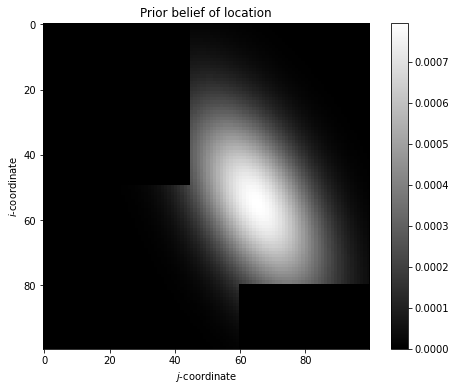

In [12]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
P_prior = np.zeros((N,N))

x_j = np.arange(N)
x_i = x_j

W = np.array([[200, 150], [150, 400]])*2 # (2,2) 배열 생성 및 성분 2배.
inv_W = np.linalg.inv(W) #역행렬
b = np.array([65, 55])

for i in range(N):
  for j in range(N):
    x = [x_j[j], x_i[i]]   #x=(1,1)성분 (2,1) ...
    P_prior[i,j] = np.exp(-(x-b).T@inv_W@(x-b)) 
    
P_prior[:50,:45] = 0
P_prior[80:,60:] = 0

P_prior /= np.sum(P_prior) #np.sum : 모든 성분의 합.--> 확률로 표현하기 위해 합으로 나눔

plt.figure(figsize=(8,6))
plt.imshow(P_prior, cmap='gray')
plt.colorbar()
plt.xlabel(r'$j$-coordinate')
plt.ylabel(r'$i$-coordinate')
plt.title('Prior belief of location') #밝은 곳 : 위치할 확률 높은 곳. 검은 곳 : 위치할 확률 0.
plt.show()



Small questions:

1. What is the sum of all the probabilities, $\sum_{i,j}P_{ij}$?


In [14]:
np.sum(P_prior)

0.9999999999999999


So in the picture, the white locations (with large $P^\text{prior}_{ij}$) are where you probably are , and the dark locations (with small $P^\text{prior}_{ij}$) are where you are not likely to be. If someone asks for the user's position _now_, you will want to find the position with highest $P^\text{prior}_{ij}$.

2. What is the location at which the user is most likely to be?

In [24]:
np.where(P_prior == np.max(P_prior))

(array([55]), array([65]))

55, 65 지점

정보를 얻기 전(H) 확률

Now your phone connects to some known base towers and records two bars of signal. For each grid location $(i,j)$, you know the probability of observing two bars from this particular tower, given that the mobile phone is in location $(i,j)$. That is, you know $P(\text{observe two bar} \mid \text{you are at} (i,j))$. We denote this probability by $P^\text{observe}_{ij}$, and the matrix $P^\text{observe}$ is shown below. Note that this value is based on knowledge of the dynamics of this particular base tower and stochasticity of signal strength. 

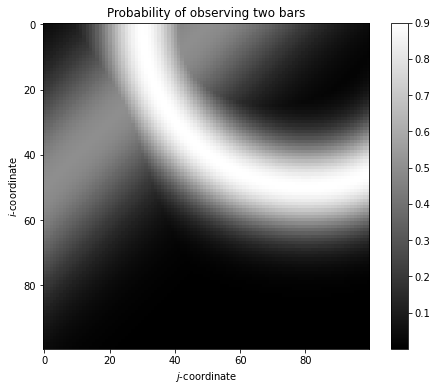

In [26]:
P_observe = np.zeros((N,N))

for i in range(N):
  for j in range(N):
    dist1 = np.linalg.norm([x_j[j]-80, x_i[i]-0])
    prob1 = np.exp(-(dist1-50)**2/200)*0.9
    dist2 = (x_j[j]+x_i[i])
    prob2 = np.exp(-(dist2-50)**2/1000)*0.5
    P_observe[i,j] = np.max([prob1, prob2])

plt.figure(figsize=(8,6))
plt.imshow(P_observe, cmap='gray')
plt.colorbar()
plt.xlabel(r'$j$-coordinate')
plt.ylabel(r'$i$-coordinate')
plt.title('Probability of observing two bars')
plt.show()


3. For each of the 10000 location positions, calculate and plot the new probability that the user is in each location given the base tower observation (the two bar observation). Recall the Bayes' theorem giving

\begin{align*}
  P\left(\text{being at } (i,j) \mid \text{observing two bars}\right)
  &= \frac{P\left(\text{observing two bars} \mid \text{being at } (i,j) \right)P(\text{being at }(i,j))}{P(\text{observing two bars})}\\
  &= \frac{P(\text{observing two bars} \mid \text{being at } (i,j) )P(\text{being at }(i,j))}{\sum_{i,j}P(\text{observing two bars} \mid \text{being at } (i,j) )P(\text{being at }(i,j))}\\
\end{align*}

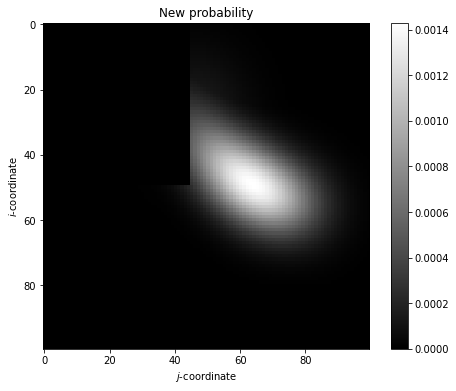

In [29]:
P_new = np.zeros((N,N))
P_sum = 0

for i in range(N):
  for j in range(N):
    P_new[i,j] = P_observe[i,j] * P_prior[i,j]
    P_sum += P_new[i,j]


plt.figure(figsize=(8,6))
plt.imshow(P_new/P_sum, cmap='gray')
plt.colorbar()
plt.xlabel(r'$j$-coordinate')
plt.ylabel(r'$i$-coordinate')
plt.title('New probability') #밝은 곳 : 위치할 확률 높은 곳. 검은 곳 : 위치할 확률 0.
plt.show()

4. Now someone _again_ asks for the user's position. What is your updated answer?


In [30]:
np.where(P_new == np.max(P_new))

(array([49]), array([64]))

49,64 지점.

---
<div style="text-align: right"> 
Contents partially taken from http://web.stanford.edu/class/cs109
</div>



